<a href="https://colab.research.google.com/github/AilingLiu/Survival_analysis/blob/master/Use_Survival_analysis_to_Estimate_Customer_Churn_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

In [2]:
url = 'https://raw.githubusercontent.com/AilingLiu/Survival_analysis/master/Data/Telco-Customer-Churn.csv'
df = pd.read_csv(url, sep=',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

# Multivariate statistical modeling

Kaplan-Meier curves and logrank tests are useful only when the predictor variable is categorical (e.g. treatment A vs treatment B; males vs females). They don’t work easily for quantitative predictors such as gene expression, weight, or age.

An alternative method is the Cox proportional hazards regression analysis, which works for both quantitative predictor variables and for categorical variables. Furthermore, the Cox regression model extends survival analysis methods to assess simultaneously the effect of several risk factors on survival time. [Referrence](http://www.sthda.com/english/wiki/cox-proportional-hazards-model)

To apply the cox model, we will need to encode the categorical variables, converting to numerical values.

## cleaning data

In [3]:
# Check the number of levels in each categorical variable
object_cols = df.drop(columns=['customerID', 'TotalCharges']).select_dtypes(include='object').columns
unique_levels = pd.DataFrame({'unique_levels': [0]*len(object_cols)}, index=object_cols)

for col in object_cols:
  unique_levels.loc[col, 'unique_levels'] = df[col].nunique()

unique_levels

,unique_levels
gender,2
Partner,2
Dependents,2
PhoneService,2
MultipleLines,3
InternetService,3
OnlineSecurity,3
OnlineBackup,3
DeviceProtection,3
TechSupport,3


In [4]:
# get dummies, and drop the first level for each variable
df_enc = pd.get_dummies(df[object_cols.tolist()+['tenure', 'MonthlyCharges']], prefix=object_cols, columns=object_cols, drop_first=True)
df_enc.head()

,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,29.85,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,34,56.95,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
2,2,53.85,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
3,45,42.30,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
4,2,70.70,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1


Note, when I start to apply coxphfitter function, it failed due to non-convergence. The reason is the suspicion is high collinearity. According to [Cam Davidson Pilon](https://github.com/CamDavidsonPilon/lifelines/blob/master/examples/Customer%20Churn.ipynb), some of the features have heirarchical natures. Such as, if one doesn't have internet service, their online security is not applicable, because `no internet service'. The best way is to treat the hierachical nature by stratifying on the different services a user may have. Here I will stratifying users based on if they have internet service on not. 
Besides, we also need to revise the 'No internet service' to no.

In [5]:
object_cols = df.drop(columns=['customerID', 'TotalCharges', 'InternetService']).select_dtypes(include='object').columns
fix_ = df[object_cols].applymap(lambda x: "No" if str(x).startswith("No ") else x)
ndf = fix_.join(df[['tenure', 'MonthlyCharges', 'InternetService', 'SeniorCitizen']])

# get dummies, and drop the first level for each variable
df_enc = pd.get_dummies(ndf, prefix=object_cols, columns=object_cols, drop_first=True)
df_enc.head()

,tenure,MonthlyCharges,InternetService,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,29.85,DSL,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
1,34,56.95,DSL,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0
2,2,53.85,DSL,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,1
3,45,42.30,DSL,0,1,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0
4,2,70.70,Fiber optic,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1


## build model

In [0]:
#pip install lifelines

In [7]:
from lifelines import CoxPHFitter

cph = CoxPHFitter().fit(df_enc, 'tenure', 'Churn_Yes', strata=['InternetService'], show_progress=True)

Iteration 1: norm_delta = 0.98279, step_size = 0.9500, log_lik = -13939.15726, newton_decrement = 1216.50145, seconds_since_start = 0.1
Iteration 2: norm_delta = 0.54478, step_size = 0.9500, log_lik = -12622.10675, newton_decrement = 114.63648, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.27378, step_size = 0.9500, log_lik = -12491.76849, newton_decrement = 16.27780, seconds_since_start = 0.2
Iteration 4: norm_delta = 0.08833, step_size = 1.0000, log_lik = -12473.37044, newton_decrement = 0.96046, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.00743, step_size = 1.0000, log_lik = -12472.36338, newton_decrement = 0.00580, seconds_since_start = 0.3
Iteration 6: norm_delta = 0.00005, step_size = 1.0000, log_lik = -12472.35755, newton_decrement = 0.00000, seconds_since_start = 0.3
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, log_lik = -12472.35755, newton_decrement = 0.00000, seconds_since_start = 0.4
Convergence success after 7 iterations.


In [8]:
cph.print_summary()

As you can see here, the `print_summary` output did not show the natural p value nor concordance value like the [documented example](https://github.com/CamDavidsonPilon/lifelines/blob/master/examples/Customer%20Churn.ipynb). I've raised this question on stackoverflow. But we can get the concordance index as below. Since -log2(p) is infinite, the p should be very small.

In [0]:
cph.concordance_index_

0.845766778773345

## Interpretation

In [0]:
cph.summary.sort_values(by='coef', ascending=True).round(4)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
Contract_Two year,-2.9849,0.0505,0.1677,-3.3136,-2.6562,0.0364,0.0702,-17.7995,0.0000,233.0229
Contract_One year,-1.5518,0.2119,0.0881,-1.7245,-1.3792,0.1783,0.2518,-17.6186,0.0000,228.3874
OnlineBackup_Yes,-0.6450,0.5247,0.1269,-0.8936,-0.3964,0.4092,0.6728,-5.0845,0.0000,21.3713
OnlineSecurity_Yes,-0.6308,0.5322,0.1330,-0.8915,-0.3701,0.4100,0.6907,-4.7419,0.0000,18.8494
Partner_Yes,-0.5240,0.5922,0.0553,-0.6323,-0.4156,0.5314,0.6599,-9.4799,0.0000,68.4125
MultipleLines_Yes,-0.4411,0.6433,0.1262,-0.6886,-0.1937,0.5023,0.8239,-3.4941,0.0005,11.0375
TechSupport_Yes,-0.3899,0.6771,0.1322,-0.6490,-0.1308,0.5226,0.8774,-2.9491,0.0032,8.2936
DeviceProtection_Yes,-0.3065,0.7360,0.1253,-0.5521,-0.0610,0.5758,0.9408,-2.4470,0.0144,6.1173
PaymentMethod_Credit card (automatic),-0.0937,0.9105,0.0908,-0.2717,0.0842,0.7621,1.0878,-1.0328,0.3017,1.7289
gender_Male,-0.0936,0.9106,0.0465,-0.1847,-0.0025,0.8313,0.9975,-2.0148,0.0439,4.5087


There are 7k+ customers in this dataset, 1869 of them have churned.

What we see here is the coefficients as the effects to customer churn risk. The negative indicates customer with that feature is less likely to churn, while the positive coefficients indicate the opposite.

Here, there are four features that have significant impact (p value extremely small) to lower churn risk:

* contract two year
* contract one year
* online backup
* online security

The concordance of this model is 0.86. I found this [article](https://medium.com/analytics-vidhya/concordance-index-72298c11eac7) really helpful to understand what concordance means. In this case, our prediction is not bad at all.


In [0]:
cph.check_assumptions(df_enc)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable 'MultipleLines_Yes' failed the non-proportional test: p-value is 0.0126.

   Advice: with so few unique values (only 2), you can include `strata=['MultipleLines_Yes', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'Contract_One year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_One year', ...]`
in the call in `.fit`. See documentation in link [E] below.

3. Variable 'Contract_Two year' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_Two year', ...]`
in the call in `.fit`. See documentation in link [E] below.

4. Variable 'PaymentMethod_Electronic check' failed the non-proportional test: p-value is 0.0035.

   Advice: with so few unique values (only 2), you can include `strata=['PaymentMethod_Electronic
check', ...]` in the call in `.fit`. See documentation in link 

It seems the features with only two level fail the non-proportional test. The suggestion here is to specify a strata. It's a good way if we want to improve our model further. Here I will leave it as it is.

Below is the visualisation plot of the coefficients shown above.

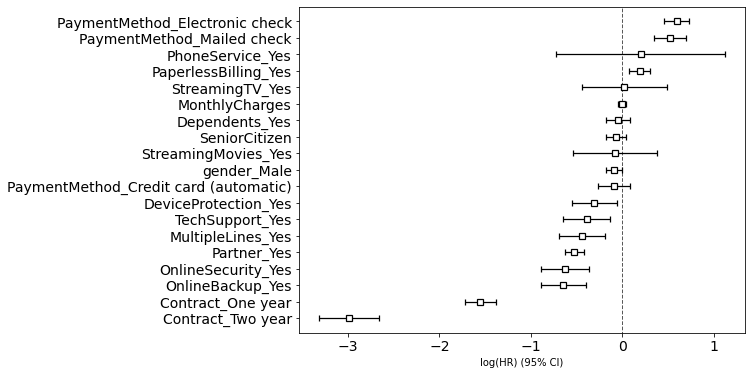

In [0]:
plt.figure(figsize=(8, 6))
cph.plot()

## check hazard risk by covariate groups

This is a very handy function to evaluate the interaction effects by multiple features. Here, we can see customer with two year contract is in a lower risk of churning than those don't have 2 year contract. In addition, those without internet service have a lower churn risk compared to those having DSL and Fiber internet service.

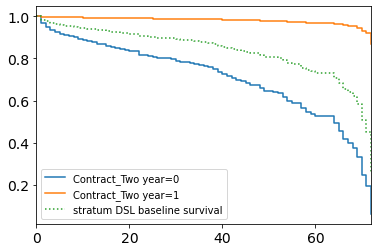

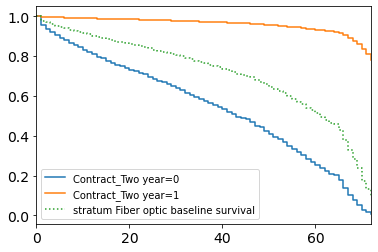

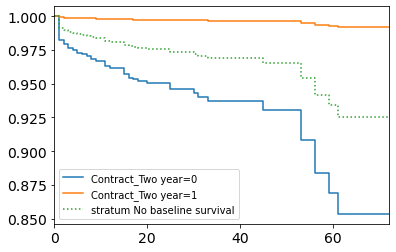

In [0]:
cph.plot_covariate_groups('Contract_Two year', values=[0, 1])

We can also see the churn effects from monthly charges covariate with internet service. Customer with DSL internet has lower churn than customer with Fiber internet. 

Customer who pays expensive service is less likely to churn than those pays little.

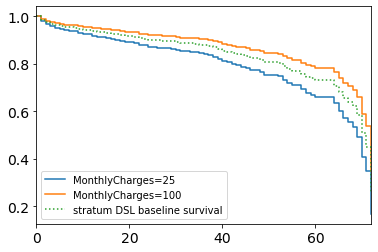

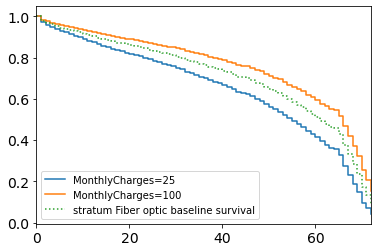

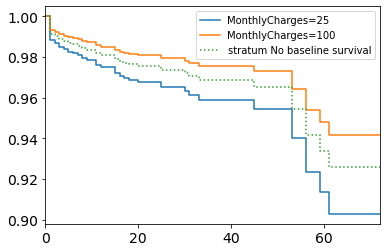

In [0]:
cph.plot_covariate_groups('MonthlyCharges', values=[25, 100])

# When is customer going to churn?

We will need to provide a training set, where there is churned and censored cases, and also test set, where there is only censored cases, meaning, custoer is still with us, but we want to know when they are likely to churn.

In [101]:
testset = df_enc[df_enc['Churn_Yes']==0].sample(n=300, random_state=42)
trainset = df_enc[~df_enc.index.isin(testset.index)]
trainset.shape

(6743, 22)

In [10]:
testset.shape

(300, 22)

In [102]:
cph = CoxPHFitter()

cph.fit(trainset, 'tenure', 'Churn_Yes', strata=['InternetService'])
cph.print_summary()

In [103]:
cph.concordance_index_

0.8431988511092107

In [104]:
preds = cph.predict_survival_function(testset)
preds.head()

,1679,5089,2253,917,4318,7007,5542,2403,2648,5605,2215,1752,3747,4584,2903,5473,4130,3748,398,3052,3816,836,6093,1433,4066,5403,5206,4866,6511,86,1204,1641,5656,6855,4110,6020,6260,375,3855,716,...,5974,6594,3219,4068,6699,3382,221,1233,5279,2531,109,6008,1938,6094,3941,6214,5996,5752,3968,2813,6027,676,3083,1004,4581,5532,6026,5336,6471,2347,1605,1591,4504,343,5182,5124,4371,6521,6018,2838
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.815340,0.879511,0.999628,0.999343,0.992449,0.999632,0.999558,0.998183,0.945571,0.931589,0.999094,0.993334,0.970768,0.999354,0.966610,0.908549,0.933508,0.999023,0.922661,0.956339,0.999629,0.997490,0.996931,0.978205,0.996854,0.982681,0.999292,0.924956,0.997719,0.990908,0.947006,0.999741,0.900967,0.992110,0.999132,0.995316,0.995190,0.997244,0.982499,0.999322,...,0.958382,0.861718,0.997587,0.981307,0.991946,0.998834,0.998518,0.998578,0.998832,0.998390,0.998150,0.982904,0.880065,0.996758,0.953893,0.993882,0.996390,0.998440,0.997659,0.996121,0.998704,0.989798,0.995211,0.889527,0.993896,0.996456,0.934248,0.889241,0.991628,0.990995,0.996080,0.940034,0.986777,0.975223,0.991613,0.996191,0.994689,0.997590,0.993888,0.993306
2.0,0.737106,0.825449,0.999444,0.999019,0.988738,0.999450,0.999339,0.997286,0.919781,0.899534,0.998647,0.990057,0.956641,0.999035,0.950525,0.866499,0.902304,0.998540,0.886684,0.935475,0.999445,0.996252,0.995419,0.967611,0.995303,0.974235,0.998942,0.889982,0.996594,0.986447,0.921867,0.999613,0.855716,0.988234,0.998704,0.993009,0.992822,0.995885,0.973964,0.998987,...,0.952413,0.843073,0.997233,0.978589,0.990768,0.998662,0.998300,0.998370,0.998661,0.998154,0.997878,0.980416,0.863694,0.996282,0.947298,0.992986,0.995861,0.998211,0.997316,0.995552,0.998513,0.988308,0.994509,0.874352,0.993002,0.995936,0.924955,0.874030,0.990403,0.989678,0.995505,0.931529,0.984848,0.971634,0.990386,0.995633,0.993910,0.997236,0.992992,0.992326
3.0,0.677192,0.782592,0.999289,0.998747,0.985631,0.999297,0.999156,0.996533,0.898651,0.873449,0.998271,0.987311,0.944927,0.998767,0.937214,0.832667,0.876887,0.998135,0.857535,0.918292,0.999291,0.995213,0.994149,0.958797,0.994001,0.967193,0.998649,0.861613,0.995649,0.982712,0.901256,0.999506,0.819449,0.984989,0.998344,0.991075,0.990836,0.994744,0.966849,0.998706,...,0.945742,0.822578,0.996835,0.975540,0.989444,0.998470,0.998055,0.998135,0.998468,0.997888,0.997572,0.977625,0.845638,0.995747,0.939932,0.991979,0.995265,0.997953,0.996929,0.994913,0.998299,0.986633,0.993719,0.857589,0.991997,0.995352,0.914610,0.857227,0.989027,0.988199,0.994858,0.922052,0.982682,0.967611,0.989008,0.995005,0.993035,0.996838,0.991986,0.991224
4.0,0.628982,0.747076,0.999155,0.998509,0.982932,0.999164,0.998996,0.995878,0.880640,0.851342,0.997944,0.984925,0.934840,0.998534,0.925770,0.804274,0.855330,0.997782,0.832925,0.903581,0.999157,0.994309,0.993044,0.951184,0.992868,0.961099,0.998393,0.837638,0.994827,0.979471,0.883678,0.999412,0.789111,0.982170,0.998030,0.989393,0.989110,0.993752,0.960693,0.998461,...,0.942056,0.811409,0.996613,0.973850,0.988709,0.998363,0.997919,0.998004,0.998361,0.997740,0.997403,0.976077,0.835772,0.995450,0.935865,0.991420,0.994935,0.997810,0.996715,0.994557,0.998180,0.985705,0.993281,0.848416,0.991439,0.995027,0.908914,0.848034,0.988263,0.987378,0.994500,0.916829,0.981482,0.965384,0.988243,0.994656,0.

The predictions are the survival function at each time t (as index) for each customer (as column).

Pick a customer at row `1679` to check its survival curve.

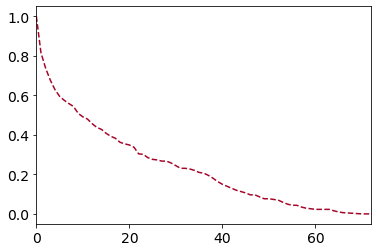

In [105]:
subject = 1679
preds[subject].plot(ls="--", color="#A60628", label="prediction");

Check [Carl's article](https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5), he pointed out that by the prediction/data collection time, the customers are 'alive'(still with the business product), so we can condition that into our prediction, so that the survival among the censored data at prediction time is 1, and the remaining timing would be weighted.

In [106]:
#take the survival probability from the prediction at the time t corresponding to 
# the tenure from testset of each customer
# clip the values exceeding 1
conditioned_prediction = preds.apply(lambda c: (c / c.loc[testset.loc[c.name, 'tenure']]).clip_upper(1)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  """Entry point for launching an IPython kernel.


In [107]:
df.loc[1679, :]

customerID              0999-QXNSA
gender                        Male
SeniorCitizen                    1
Partner                         No
Dependents                     Yes
tenure                           7
PhoneService                   Yes
MultipleLines                   No
InternetService                DSL
OnlineSecurity                  No
OnlineBackup                    No
DeviceProtection                No
TechSupport                     No
StreamingTV                     No
StreamingMovies                 No
Contract            Month-to-month
PaperlessBilling               Yes
PaymentMethod         Mailed check
MonthlyCharges               45.75
TotalCharges                 344.2
Churn                           No
Name: 1679, dtype: object

In [108]:
conditioned_prediction.loc[:15, 1679].round(4)

0.0     1.0000
1.0     1.0000
2.0     1.0000
3.0     1.0000
4.0     1.0000
5.0     1.0000
6.0     1.0000
7.0     1.0000
8.0     0.9734
9.0     0.9115
10.0    0.8798
11.0    0.8594
12.0    0.8179
13.0    0.7840
14.0    0.7663
15.0    0.7307
Name: 1679, dtype: float64

The subject 1679 corresponds to the customer id '0999-QXNSA', whose tenure is 7 months at collection time, and has not churned. With the conditioned prediction, we can see the survival function from month 0 to 7 are 1, and slowly decrease after month 7.

With the same customer, we can compare the unconditioned and conditioned prediction in below graph.

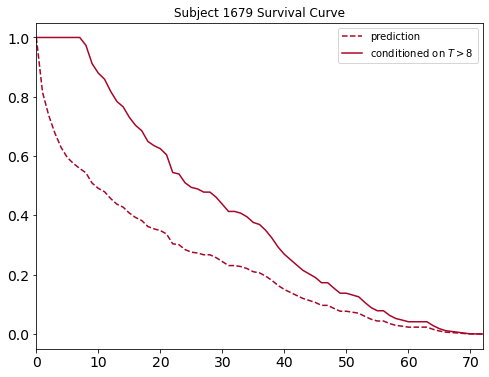

In [109]:
subject = 1679
plt.figure(figsize=(8, 6))
preds[subject].plot(ls="--", color="#A60628", label="prediction");
conditioned_prediction[subject].plot(color="#A60628", label="conditioned on $T>8$") 
plt.title('Subject 1679 Survival Curve')
plt.legend();

By giving condition that we know what is the current tenure of customer is (since he/she has not left us), we can achieve a better prediction.

From the conditioned prediction, customer is less likely to churn at each time t compared to the unconditional prediction. We can see that at about 30 months, 50% chance that this customer is likely to churn.

## Average churn time and remaining revenue

In [110]:
from lifelines.utils import qth_survival_times 

predictions_50 = qth_survival_times(0.5, conditioned_prediction) 
predictions_50

,1679,5089,2253,917,4318,7007,5542,2403,2648,5605,2215,1752,3747,4584,2903,5473,4130,3748,398,3052,3816,836,6093,1433,4066,5403,5206,4866,6511,86,1204,1641,5656,6855,4110,6020,6260,375,3855,716,...,5974,6594,3219,4068,6699,3382,221,1233,5279,2531,109,6008,1938,6094,3941,6214,5996,5752,3968,2813,6027,676,3083,1004,4581,5532,6026,5336,6471,2347,1605,1591,4504,343,5182,5124,4371,6521,6018,2838
0.5,25.0,39.0,inf,inf,inf,inf,inf,inf,64.0,53.0,inf,inf,67.0,inf,66.0,49.0,53.0,inf,57.0,66.0,inf,inf,inf,70.0,inf,72.0,inf,53.0,inf,inf,59.0,inf,35.0,inf,inf,inf,inf,inf,72.0,inf,...,inf,56.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,56.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,61.0,inf,inf,inf,56.0,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


In [44]:
avg_ = predictions_50.T.join(testset.loc[:, ['MonthlyCharges', 'tenure']])
avg_['RemainingRevenue'] = avg_['MonthlyCharges']*(avg_.iloc[:, 0] - avg_.iloc[:, 2])
avg_.rename(columns={0.5: 'Expected_Tenure'}, inplace=True)
avg_.head()

,Expected_Tenure,MonthlyCharges,tenure,RemainingRevenue
1679,27.0,45.75,7,915.0
5089,39.0,54.40,8,1686.4
2253,inf,74.40,72,inf
917,inf,65.55,72,inf
4318,inf,75.75,56,inf


In [47]:
sum(avg_['Expected_Tenure']==np.inf)/len(avg_)

0.6266666666666667

The returned table showed the expected tenure of each censored customer(alive), and the remaining revenue before reaching to that tenure.

I run into 63% of the data that has a long survival curve, i.e. customers are not half way to their survival curve. As we checked on the contract type before, customer with the annual contracts tend to have a longer survival curve than the monthly one. We should stratify our model into 3 contrat types, and check again on the expected tenure. Further, for the problem of insufficient data(data less than 3 years record), one of the data scientist deal with it by introducing poisson distribution. Check [here](https://www.youtube.com/watch?v=f3ua_dDjTNU&t=285s) for details.



## Average churning time of Monthly Contract

In [112]:
monthly = df.loc[df['Contract']=='Month-to-month']
monthly['Churn'].value_counts()

No     2220
Yes    1655
Name: Churn, dtype: int64

In [52]:
monthly.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [113]:
monthly = monthly.applymap(lambda x: "No" if str(x).startswith("No ") else x)
monthly_enc = pd.get_dummies(monthly.drop(columns=['customerID', 'TotalCharges', 'InternetService']), 
                             drop_first=True)

monthlydf = monthly_enc.join(monthly['InternetService'])
monthlydf.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,InternetService
0,0,1,29.85,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,DSL
2,0,2,53.85,1,0,0,1,0,1,1,0,0,0,0,1,0,0,1,1,DSL
4,0,2,70.70,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,Fiber optic
5,0,8,99.65,0,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,Fiber optic
6,0,22,89.10,1,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,Fiber optic


In [114]:
mtest = monthlydf.loc[monthlydf['Churn_Yes']==0].sample(n=300, replace=False, 
                                                          random_state=42)
mtrain=monthlydf.loc[~monthlydf.index.isin(mtest.index)]
print(mtrain.shape)
print(mtest.shape)

(3575, 20)
(300, 20)


In [115]:
cph = CoxPHFitter()

cph.fit(mtrain, duration_col='tenure', event_col='Churn_Yes', 
        strata=['InternetService'],show_progress=True)


Iteration 1: norm_delta = 0.57852, step_size = 0.9500, log_lik = -11031.60541, newton_decrement = 356.41916, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.14607, step_size = 0.9500, log_lik = -10654.15447, newton_decrement = 12.39985, seconds_since_start = 0.1
Iteration 3: norm_delta = 0.01423, step_size = 0.9500, log_lik = -10641.43144, newton_decrement = 0.12764, seconds_since_start = 0.1
Iteration 4: norm_delta = 0.00010, step_size = 1.0000, log_lik = -10641.30323, newton_decrement = 0.00001, seconds_since_start = 0.2
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -10641.30322, newton_decrement = 0.00000, seconds_since_start = 0.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 3575 total observations, 1920 right-censored observations>

In [116]:
valid_coef = cph.summary.loc[cph.summary['p']<0.05]
sorted_sum = valid_coef.iloc[valid_coef['coef'].abs().argsort()].round(4)
sorted_sum

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
gender_Male,-0.1265,0.8812,0.0495,-0.2235,-0.0295,0.7997,0.9709,-2.5564,0.0106,6.5632
PaperlessBilling_Yes,0.1667,1.1814,0.0610,0.0472,0.2862,1.0483,1.3314,2.7336,0.0063,7.3187
DeviceProtection_Yes,-0.3140,0.7305,0.1373,-0.5830,-0.0449,0.5582,0.9561,-2.2872,0.0222,5.4941
MultipleLines_Yes,-0.4199,0.6571,0.1384,-0.6911,-0.1487,0.5010,0.8619,-3.0343,0.0024,8.6962
PaymentMethod_Mailed check,0.4444,1.5595,0.0970,0.2542,0.6346,1.2894,1.8862,4.5799,0.0000,17.7138
Partner_Yes,-0.4913,0.6119,0.0592,-0.6072,-0.3753,0.5449,0.6871,-8.3019,0.0000,53.1157
TechSupport_Yes,-0.5254,0.5913,0.1478,-0.8150,-0.2358,0.4426,0.7899,-3.5558,0.0004,11.3735
PaymentMethod_Electronic check,0.5360,1.7092,0.0790,0.3813,0.6908,1.4641,1.9953,6.7886,0.0000,36.3616
OnlineBackup_Yes,-0.6591,0.5173,0.1397,-0.9328,-0.3853,0.3934,0.6802,-4.7186,0.0000,18.6839
OnlineSecurity_Yes,-0.6909,0.5011,0.1466,-0.9782,-0.4035,0.3760,0.6680,-4.7122,0.0000,18.6385


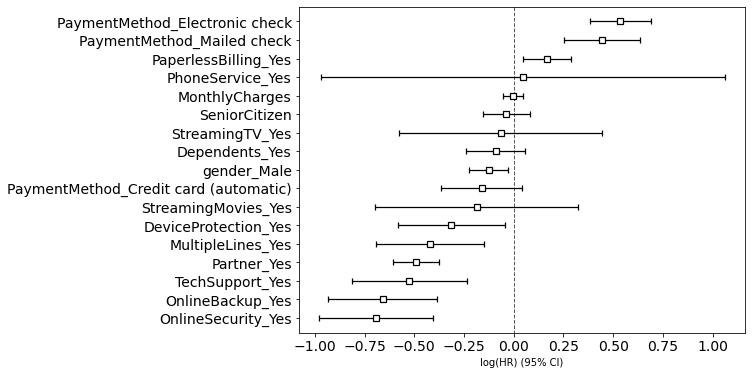

In [117]:
plt.figure(figsize=(8, 6))
cph.plot();

What it shows here is there are 10 predictors have significant effects on churn risks. Among which, 

* online security yes
* online back up yes
* technical supoort yes
* partner yes

have strong effects of lower risk of churn. 

In [118]:
preds.apply(lambda c: (c / c.loc[testset.loc[c.name, 'tenure']]).clip_upper(1)) 

uncondition_mtest = cph.predict_survival_function(mtest)
condition_test = uncondition_mtest.apply(lambda c: (c/c.loc[mtest.loc[c.name, 'tenure']]).clip_upper(1))

condition_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  after removing the cwd from sys.path.


,4644,2437,2251,1716,348,4865,5440,616,3747,1305,1813,6693,6651,4922,2261,6061,2478,356,3893,3341,322,3599,7029,1020,6387,5403,1777,1583,1881,2712,5052,244,1894,424,2771,5546,782,6950,5013,718,...,5141,4676,3027,5007,6564,5866,6944,2999,556,1518,6449,169,2425,5676,5574,4225,1432,1151,3323,3005,760,6648,579,5506,1393,3097,6011,1355,5150,5753,5563,5455,4971,798,3865,3793,4475,2141,3937,6761
1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,0.959650,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.874818,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,0.988667,1.0,0.984445,1.0,1.0,0.990449,1.0,1.0,1.0,0.980653,1.0,1.0,0.984498,1.0,1.000000,0.984472,0.982404,1.000000,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.0,0.989175,0.989508,1.0,1.000000,1.0,1.000000,0.981667
3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,0.926302,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.779904,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.0,0.969372,1.0,0.958113,1.0,1.0,0.974146,1.0,1.0,1.0,0.948074,1.0,1.0,0.958255,1.0,0.968487,0.958187,0.952704,0.975598,1.0,1.0,0.988020,0.982680,1.000000,1.0,1.0,0.970732,0.971622,1.0,1.000000,1.0,1.000000,0.950752
4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,0.898040,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,0.705253,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.982036,0.982009,1.0,0.958616,1.0,0.943521,1.0,1.0,0.965037,1.0,1.0,1.0,0.930113,1.0,1.0,0.943710,1.0,0.951089,0.943619,0.936290,0.962048,1.0,1.0,0.981301,0.973009,1.000000,1.0,1.0,0.960444,0.961641,1.0,0.981092,1.0,1.000000,0.933685
5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.992001,1.0,0.878426,1.0,1.0,1.0,1.0,1.0,0.946087,1.0,1.0,1.0,0.656451,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.991872,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.956055,0.955990,1.0,0.942926,1.0,0.922342,1.0,1.0,0.951719,1.0,1.0,1.0,0.904169,1.0,1.0,0.922600,1.0,0.925927,0.922476,0.912528,0.942351,1.0,1.0,0.971448,0.958878,0.974608,1.0,1.0,0.945426,0.947065,1.0,0.953777,1.0,0.983546,0.909000


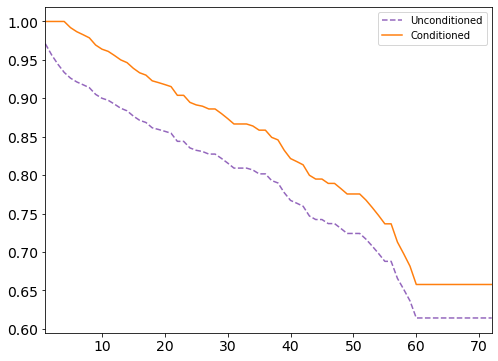

In [119]:
subject = 3747
plt.figure(figsize=(8, 6))
uncondition_mtest[subject].plot(ls='--', color='tab:purple', label='Unconditioned')
condition_test[subject].plot(color='tab:orange', label='Conditioned')
plt.legend();

This customer currently is at 4th month in the product use. Its survival curve drops steadly until at month 60th, where it flatten out without much change.

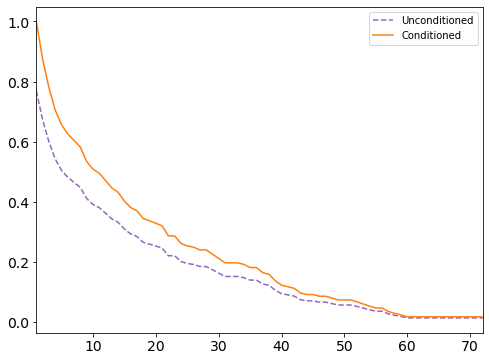

In [120]:
subject = 322
plt.figure(figsize=(8, 6))
uncondition_mtest[subject].plot(ls='--', color='tab:purple', label='Unconditioned')
condition_test[subject].plot(color='tab:orange', label='Conditioned')
plt.legend();

This customer have 50% of churn risk at the 15th month.

In [82]:
mtest.loc[322]

SeniorCitizen                               0
tenure                                      1
MonthlyCharges                           44.8
gender_Male                                 1
Partner_Yes                                 0
Dependents_Yes                              0
PhoneService_Yes                            1
MultipleLines_Yes                           0
OnlineSecurity_Yes                          0
OnlineBackup_Yes                            0
DeviceProtection_Yes                        0
TechSupport_Yes                             0
StreamingTV_Yes                             0
StreamingMovies_Yes                         0
PaperlessBilling_Yes                        1
PaymentMethod_Credit card (automatic)       0
PaymentMethod_Electronic check              1
PaymentMethod_Mailed check                  0
Churn_Yes                                   0
InternetService                           DSL
Name: 322, dtype: object

This customer does not have the features such as online security, online backup features that the cox regression model suggests to bring negative effect on churn risk; instead, he has features that are positive in the cox regression model, indicating this customer is more likely to churn at an early age.

In [121]:
predictions_50 = qth_survival_times(0.5, condition_test) 
avg_ = predictions_50.T.join(mtest.loc[:, ['MonthlyCharges', 'tenure']])
avg_['RemainingRevenue'] = avg_['MonthlyCharges']*(avg_.iloc[:, 0] - avg_.iloc[:, 2])
avg_.rename(columns={0.5: 'Expected_Tenure'}, inplace=True)
#below shows the ordered customers from smallest remaining tenure to largest
avg_.assign(f = avg_['Expected_Tenure']-avg_['tenure']).sort_values('f').drop('f', axis=1)

,Expected_Tenure,MonthlyCharges,tenure,RemainingRevenue
3783,71.0,105.20,66,526.00
4626,68.0,89.60,63,448.00
6222,71.0,89.40,66,447.00
1206,10.0,70.15,3,491.05
7023,70.0,103.50,63,724.50
...,...,...,...,...
1881,inf,44.65,26,inf
4091,inf,68.90,20,inf
4756,inf,72.45,31,inf
424,inf,40.70,10,inf


In [122]:
sum(avg_['Expected_Tenure']==np.inf)

61

From above, we can see only 61 monthly contract customers have not reached to median point of their survival function. 

For the rest of the customers, we can focus on the customers that are close to churning time, spending effort in retaining them.

## How to prevent churn

We know there are a few features that have negative effects in churning risk. A good way to prevent churning is to convince the customer who does not have those features to subscribe to those features too. In Carl's [blog], he did a great job in looping through all four features, and finding the differences of revenue if the features are presented. Here, I will only use one customer as example, and change its 'OnlineSecurity' feature to yes, to see how much revenue we will gain corresponding to the extended survival time, if we did convince the customer to upgrade.

In [91]:
avg_.loc[[322]]

,Expected_Tenure,MonthlyCharges,tenure,RemainingRevenue
322,11.0,44.8,1,448.0


In [127]:
subject = mtest.loc[[322]]
subject.loc[:, 'OnlineSecurity_Yes'] = 1
subject 

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,InternetService
322,0,1,44.8,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,DSL


In [145]:
from lifelines.utils import median_survival_times

unc_surv = cph.predict_survival_function(subject)
cond_surv = (unc_surv/1).clip_upper(1)
new_churn_time = median_survival_times(cond_surv)
temp_=avg_.loc[[322]].join(pd.DataFrame([], columns=['New_Expected_Tenure']))
temp_['New_Expected_Tenure'] = new_churn_time
temp_['NewRemaingRev'] = temp_['New_Expected_Tenure']  * temp_['MonthlyCharges']
temp_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  after removing the cwd from sys.path.


,Expected_Tenure,MonthlyCharges,tenure,RemainingRevenue,New_Expected_Tenure,NewRemaingRev
322,11.0,44.8,1,448.0,21.0,940.8


We can now see by upgrading the online security for customer 322(row number), we can extend its expected churning time from 11 to 21 months. Might be a good strategy to convince customer to get this service.

# Evaluation of Model